<a href="https://colab.research.google.com/github/sergiomora03/AdvancedTopicsAnalytics/blob/main/exercises/E1-UsedVehiclePricePredictionDeployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# E1 - Model Deployment in Used Vehicle Price Prediction

## Introduction

- 1.2 Million listings scraped from TrueCar.com - Price, Mileage, Make, Model dataset from Kaggle: [data](https://www.kaggle.com/jpayne/852k-used-car-listings)
- Each observation represents the price of an used car

In [ ]:

import sys
import subprocess
import importlib.util

required_packages = [
    "scikit-learn",
    "xgboost",
    "matplotlib",
    "flask-restx"
]
        
for package in required_packages:
    if importlib.util.find_spec(package) is None:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

In [1]:
import random, sys
sys.path.append( './Models' )
from Models.Proc_model import predict_price
from flask import Flask
from flask_restx import Api, Resource, fields
%matplotlib inline
import pandas as pd
import numpy as np
import joblib
import pickle
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler,OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.base import clone
import xgboost as XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import KFold, GridSearchCV,ParameterGrid, train_test_split

In [2]:
data = pd.read_csv('https://github.com/sergiomora03/AdvancedTopicsAnalytics/raw/main/datasets/dataTrain_carListings.zip')

In [3]:
data.head()

,Price,Year,Mileage,State,Make,Model
0,21490,2014,31909,MD,Nissan,MuranoAWD
1,21250,2016,25741,KY,Chevrolet,CamaroCoupe
2,20925,2016,24633,SC,Hyundai,Santa
3,14500,2012,84026,OK,Jeep,Grand
4,32488,2013,22816,TN,Jeep,Wrangler


In [4]:
data.shape

(500000, 6)

In [5]:
data.columns

Index(['Price', 'Year', 'Mileage', 'State', 'Make', 'Model'], dtype='object')

# Exercise P0.1 (50%)

Develop a machine learning model that predicts the price of the of car using as an input ['Year', 'Mileage', 'State', 'Make', 'Model']

#### Evaluation:
- 25% - Performance of the models using a manually implemented K-Fold (K=10) cross-validation
- 25% - Notebook explaining the process for selecting the best model. You must specify how the calibration of each of the parameters is done and how these change the performance of the model. It is expected that a clear comparison will be made of all implemented models.. Present the most relevant conslusions about the whole process.


In [6]:
features = ['Year', 'Mileage', 'State', 'Make', 'Model']
X = data[features]
y = data['Price']

numeric_features = ['Year', 'Mileage']
numeric_transformer = StandardScaler()

categorical_features = ['State', 'Make', 'Model']
categorical_transformer = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_transformed = preprocessor.fit_transform(X)

feature_names = (
    numeric_features +
    preprocessor.transformers_[1][1].get_feature_names_out().tolist()
)

preprocessor.fit(X)


ColumnTransformer(transformers=[('num', StandardScaler(), ['Year', 'Mileage']),
                                ('cat',
                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 ['State', 'Make', 'Model'])])

Starting 10-fold cross-validation for LinearRegression...
  Fold 1/10 - RMSE: 8971.31, MAE: 6854.48, R²: 0.3183, Time: 0.18s
  Fold 2/10 - RMSE: 8935.41, MAE: 6854.17, R²: 0.3073, Time: 0.16s
  Fold 3/10 - RMSE: 8908.70, MAE: 6826.16, R²: 0.3060, Time: 0.15s
  Fold 4/10 - RMSE: 8907.52, MAE: 6840.06, R²: 0.3114, Time: 0.16s
  Fold 5/10 - RMSE: 8927.13, MAE: 6850.80, R²: 0.3079, Time: 0.16s
  Fold 6/10 - RMSE: 9010.75, MAE: 6877.54, R²: 0.2997, Time: 0.16s
  Fold 7/10 - RMSE: 8897.71, MAE: 6821.74, R²: 0.3187, Time: 0.15s
  Fold 8/10 - RMSE: 8959.44, MAE: 6858.65, R²: 0.3050, Time: 0.15s
  Fold 9/10 - RMSE: 8874.95, MAE: 6831.67, R²: 0.3135, Time: 0.15s
  Fold 10/10 - RMSE: 8925.28, MAE: 6854.01, R²: 0.3127, Time: 0.16s
Average - RMSE: 8931.82, MAE: 6846.93, R²: 0.3100, Time: 0.16s
Starting 10-fold cross-validation for Ridge...
  Fold 1/10 - RMSE: 8971.31, MAE: 6854.48, R²: 0.3183, Time: 0.17s
  Fold 2/10 - RMSE: 8935.41, MAE: 6854.17, R²: 0.3073, Time: 0.20s
  Fold 3/10 - RMSE: 8908.70

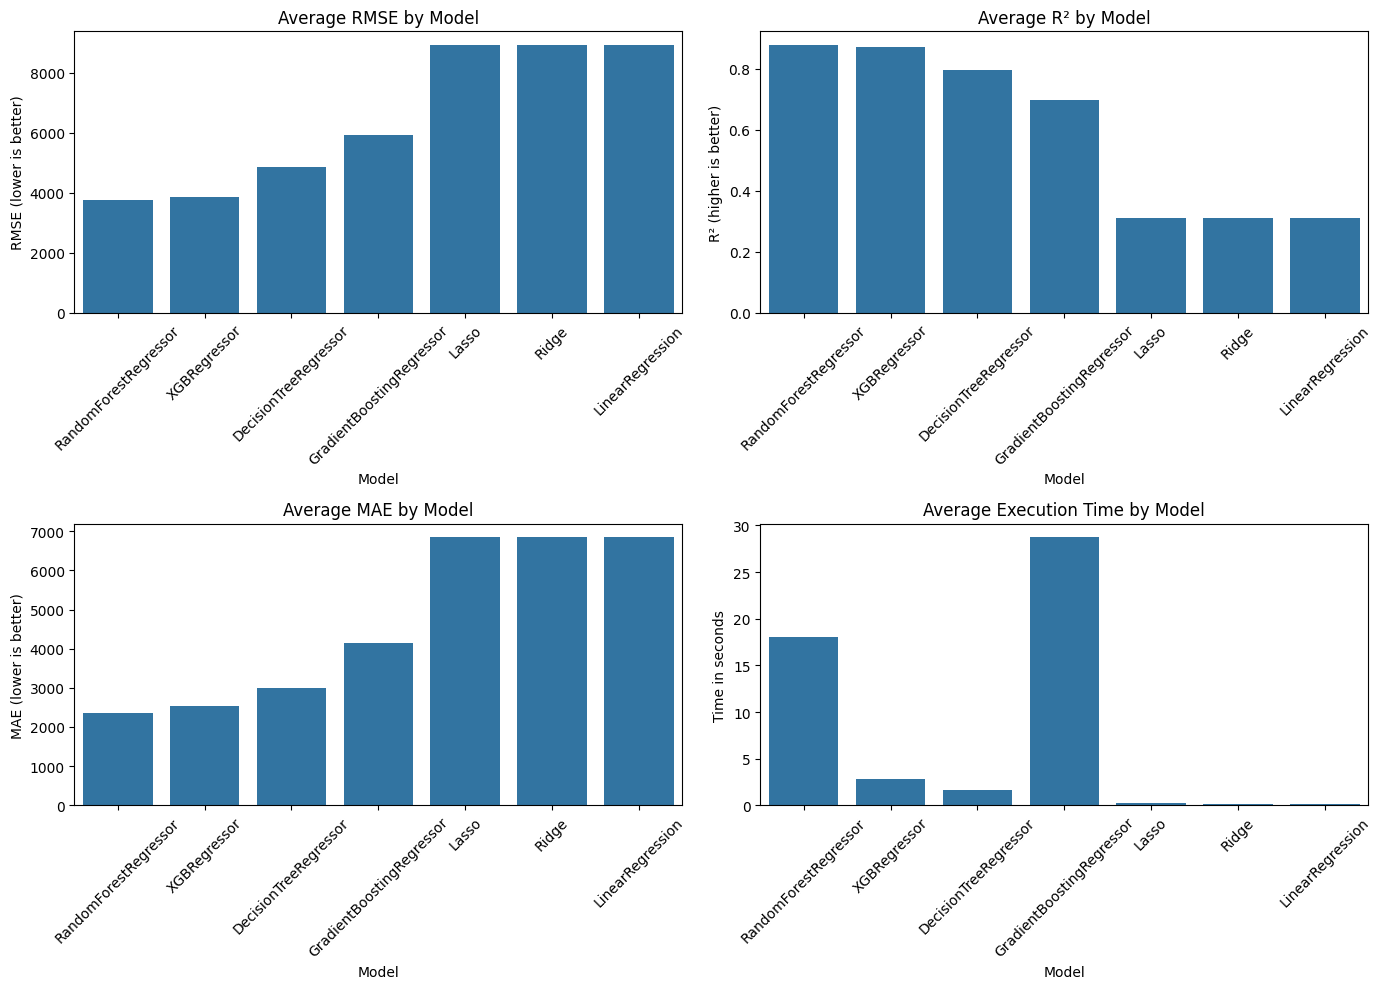

In [7]:
def manual_kfold_cv(X, y, model, k=10, random_state=42):
    kf = KFold(n_splits=k, shuffle=True, random_state=random_state)
    
    rmse_scores = []
    mae_scores = []
    r2_scores = []
    fold_times = []
    
    print(f"Starting {k}-fold cross-validation for {model.__class__.__name__}...")
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(X, y), 1):
        start_time = time.time()
        
        X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
        y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]
    
        X_train_transformed = preprocessor.transform(X_train_fold)
        X_test_transformed = preprocessor.transform(X_test_fold)
        
        model.fit(X_train_transformed, y_train_fold)
        
        y_pred = model.predict(X_test_transformed)
        rmse = np.sqrt(mean_squared_error(y_test_fold, y_pred))
        mae = mean_absolute_error(y_test_fold, y_pred)
        r2 = r2_score(y_test_fold, y_pred)
        
        rmse_scores.append(rmse)
        mae_scores.append(mae)
        r2_scores.append(r2)
        
        fold_time = time.time() - start_time
        fold_times.append(fold_time)
        
        print(f"  Fold {fold}/{k} - RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.4f}, Time: {fold_time:.2f}s")
    
    avg_rmse = np.mean(rmse_scores)
    avg_mae = np.mean(mae_scores)
    avg_r2 = np.mean(r2_scores)
    avg_time = np.mean(fold_times)
    
    print(f"Average - RMSE: {avg_rmse:.2f}, MAE: {avg_mae:.2f}, R²: {avg_r2:.4f}, Time: {avg_time:.2f}s")
    
    return {
        'model': model.__class__.__name__,
        'rmse_scores': rmse_scores,
        'mae_scores': mae_scores,
        'r2_scores': r2_scores,
        'avg_rmse': avg_rmse,
        'avg_mae': avg_mae,
        'avg_r2': avg_r2,
        'avg_time': avg_time,
        'fold_times': fold_times
    }

models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor.XGBRegressor(random_state=42, n_jobs=-1)
}

results = {}
for name, model in models.items():
    results[name] = manual_kfold_cv(X, y, model)

comparison_df = pd.DataFrame({
    'Model': [results[name]['model'] for name in models.keys()],
    'Avg RMSE': [results[name]['avg_rmse'] for name in models.keys()],
    'Avg MAE': [results[name]['avg_mae'] for name in models.keys()],
    'Avg R²': [results[name]['avg_r2'] for name in models.keys()],
    'Avg Time (s)': [results[name]['avg_time'] for name in models.keys()]
})


comparison_df = comparison_df.sort_values('Avg RMSE')
print("\nModel comparison (sorted by RMSE):")
print(comparison_df)
plt.figure(figsize=(14, 10))

# RMSE comparison
plt.subplot(2, 2, 1)
sns.barplot(x='Model', y='Avg RMSE', data=comparison_df)
plt.title('Average RMSE by Model')
plt.xticks(rotation=45)
plt.ylabel('RMSE (lower is better)')

# R² comparison
plt.subplot(2, 2, 2)
sns.barplot(x='Model', y='Avg R²', data=comparison_df)
plt.title('Average R² by Model')
plt.xticks(rotation=45)
plt.ylabel('R² (higher is better)')

# MAE comparison
plt.subplot(2, 2, 3)
sns.barplot(x='Model', y='Avg MAE', data=comparison_df)
plt.title('Average MAE by Model')
plt.xticks(rotation=45)
plt.ylabel('MAE (lower is better)')

# Time comparison
plt.subplot(2, 2, 4)
sns.barplot(x='Model', y='Avg Time (s)', data=comparison_df)
plt.title('Average Execution Time by Model')
plt.xticks(rotation=45)
plt.ylabel('Time in seconds')

plt.tight_layout()
plt.savefig('./Imagenes/model_comparison.png')
plt.show()


# hyperparameter

In [8]:
top_model_classes  = comparison_df.head(3)['Model'].values
print(f"\nTop 3 models for hyperparameter tuning: {top_model_classes }")

model_name_mapping = {
    'LinearRegression': 'Linear Regression',
    'Ridge': 'Ridge Regression',
    'Lasso': 'Lasso Regression',
    'DecisionTreeRegressor': 'Decision Tree',
    'RandomForestRegressor': 'Random Forest',
    'GradientBoostingRegressor': 'Gradient Boosting',
    'XGBRegressor': 'XGBoost'
}

top_models = [model_name_mapping.get(model_class, model_class) for model_class in top_model_classes]

param_grids = {}

if 'Linear Regression' in top_models:
    param_grids['Linear Regression'] = {
        'fit_intercept': [True, False],
        'positive': [True, False],
        'n_jobs': [-1]
    }

if 'Ridge Regression' in top_models:
    param_grids['Ridge Regression'] = {
        'alpha': [0.01, 0.1, 1.0, 10.0, 100.0],
        'fit_intercept': [True, False],
        'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
    }

if 'Lasso Regression' in top_models:
    param_grids['Lasso Regression'] = {
        'alpha': [0.01, 0.1, 1.0, 10.0, 100.0],
        'fit_intercept': [True, False],
        'selection': ['cyclic', 'random']
    }

if 'Decision Tree' in top_models:
    param_grids['Decision Tree'] = {
        'max_depth': [None, 10, 20, 30, 40, 50],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': [None, 'sqrt', 'log2']
    }

if 'Random Forest' in top_models:
    param_grids['Random Forest'] = {
        'n_estimators': [20, 30, 40],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': [None, 'sqrt', 'log2']
    }

if 'Gradient Boosting' in top_models:
    param_grids['Gradient Boosting'] = {
        'n_estimators': [20, 30, 40],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'subsample': [0.8, 1.0]
    }

if 'XGBoost' in top_models:
    param_grids['XGBoost'] = {
        'n_estimators': [20, 30, 40],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'gamma': [0, 0.1, 0.2]
    }


Top 3 models for hyperparameter tuning: ['RandomForestRegressor' 'XGBRegressor' 'DecisionTreeRegressor']


In [9]:
def hyperparameter_tuning(X, y, model_name, param_grid, cv=5, n_iter_no_change=2, tol=0.0005):
    
    print(f"\nHyperparameter tuning for {model_name}...")
    
    model = models[model_name]
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    tuning_param_grid = {'regressor__' + key: value for key, value in param_grid.items()}
    
    param_list = list(ParameterGrid(tuning_param_grid))
    print(f"Total parameter combinations: {len(param_list)}")
    
    best_score = float('-inf')
    best_params = None
    best_estimator = None
    no_improvement_count = 0
    tested_params = 0

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    start_time = time.time()
    
    for params in param_list:
        tested_params += 1
        pipeline.set_params(**params)
        
        try:
            pipeline.fit(X_train, y_train)
            
            # Evaluate
            y_pred = pipeline.predict(X_val)
            current_score = -np.sqrt(mean_squared_error(y_val, y_pred))
            
            print(f"Parameters {tested_params}/{len(param_list)}: RMSE = {-current_score:.4f}")
            
            if current_score > best_score + tol:
                best_score = current_score
                best_params = params
                best_estimator = clone(pipeline)
                best_estimator.set_params(**params)
                no_improvement_count = 0
            else:
                no_improvement_count += 1
            
            if no_improvement_count >= n_iter_no_change:
                print(f"Early stopping after {tested_params}/{len(param_list)} combinations: "
                      f"No improvement for {n_iter_no_change} consecutive parameter sets")
                break
                
        except Exception as e:
            print(f"Error with parameters {params}: {str(e)}")
            continue
    
    if best_estimator is not None:
        print("Fitting final model with best parameters...")
        best_estimator.fit(X, y)
    
    tuning_time = time.time() - start_time
    
    print(f"Best parameters: {best_params}")
    print(f"Best RMSE: {-best_score:.4f}")
    print(f"Tuning time: {tuning_time:.2f} seconds")
    print(f"Tested {tested_params}/{len(param_list)} parameter combinations ({tested_params/len(param_list)*100:.1f}%)")
    
    return best_estimator, best_params, -best_score, tuning_time

tuned_models = {}
tuning_results = {}

for model_name in top_models:
    if model_name in param_grids:
        best_model, best_params, best_rmse, tuning_time = hyperparameter_tuning(
            X, y, model_name, param_grids[model_name]
        )
        tuned_models[model_name] = best_model
        tuning_results[model_name] = {
            'best_params': best_params,
            'best_rmse': best_rmse,
            'tuning_time': tuning_time
        }

print("\nEvaluating tuned models...")
tuned_results = {}

for name, model in tuned_models.items():
    tuned_regressor = model.named_steps['regressor']
    tuned_results[name] = manual_kfold_cv(X, y, tuned_regressor)


Hyperparameter tuning for Random Forest...
Total parameter combinations: 324
Parameters 1/324: RMSE = 3872.0585
Parameters 2/324: RMSE = 3852.4387
Parameters 3/324: RMSE = 3839.1778
Parameters 4/324: RMSE = 3776.1552
Parameters 5/324: RMSE = 3761.7968
Parameters 6/324: RMSE = 3752.0108
Parameters 7/324: RMSE = 3683.2979
Parameters 8/324: RMSE = 3672.1932
Parameters 9/324: RMSE = 3664.7040
Parameters 10/324: RMSE = 3758.7612
Parameters 11/324: RMSE = 3745.8297
Early stopping after 11/324 combinations: No improvement for 2 consecutive parameter sets
Fitting final model with best parameters...
Best parameters: {'regressor__max_depth': None, 'regressor__max_features': None, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 10, 'regressor__n_estimators': 40}
Best RMSE: 3664.7040
Tuning time: 60.19 seconds
Tested 11/324 parameter combinations (3.4%)

Hyperparameter tuning for XGBoost...
Total parameter combinations: 972
Parameters 1/972: RMSE = 10198.4481
Parameters 2/972: R

# Select best model

In [10]:

tuned_comparison_df = pd.DataFrame({
    'Model': [tuned_results[name]['model'] for name in tuned_models.keys()],
    'Avg RMSE': [tuned_results[name]['avg_rmse'] for name in tuned_models.keys()],
    'Avg MAE': [tuned_results[name]['avg_mae'] for name in tuned_models.keys()],
    'Avg R²': [tuned_results[name]['avg_r2'] for name in tuned_models.keys()],
    'Tuning Time (s)': [tuning_results[name]['tuning_time'] for name in tuned_models.keys()]
})

tuned_comparison_df = tuned_comparison_df.sort_values('Avg RMSE')
print("\nTuned model comparison (sorted by RMSE):")
display(tuned_comparison_df)

comparison_data = []

for name in tuned_models.keys():
    original_metrics = results[name]
    tuned_metrics = tuned_results[name]
    
    comparison_data.append({
        'Model': name,
        'Original RMSE': original_metrics['avg_rmse'],
        'Tuned RMSE': tuned_metrics['avg_rmse'],
        'RMSE Improvement': original_metrics['avg_rmse'] - tuned_metrics['avg_rmse'],
        'Original R²': original_metrics['avg_r2'],
        'Tuned R²': tuned_metrics['avg_r2'],
        'R² Improvement': tuned_metrics['avg_r2'] - original_metrics['avg_r2']
    })

improvement_df = pd.DataFrame(comparison_data)
print("\nImprovement after hyperparameter tuning:")
display(improvement_df)

best_model_rmse = improvement_df.loc[improvement_df['Tuned RMSE'].idxmin(), 'Model']
best_model_r2 = improvement_df.loc[improvement_df['Tuned R²'].idxmax(), 'Model']
print("--------------------------------------------")
print(f"Best model according to RMSE: {best_model_rmse}")
print(f"Best model according to R²: {best_model_r2}")


best_model_name = best_model_rmse
best_model = tuned_models[best_model_name]
best_preprocessor = tuned_results[best_model_name].get('preprocessor', preprocessor)


joblib.dump(best_model, './Models/Best_model.pkl')
joblib.dump(best_preprocessor, './Models/preprocessor.pkl')

print(f"Modelo {best_model_name} saved at './Models/{best_model_name}.pkl'")


Tuned model comparison (sorted by RMSE):


,Model,Avg RMSE,Avg MAE,Avg R²,Tuning Time (s)
0,RandomForestRegressor,3602.857545,2264.991786,0.887730,60.192136
2,DecisionTreeRegressor,4275.389180,2672.863922,0.841909,9.560765
1,XGBRegressor,9693.053379,7572.754590,0.187445,3.152409



Improvement after hyperparameter tuning:


,Model,Original RMSE,Tuned RMSE,RMSE Improvement,Original R²,Tuned R²,R² Improvement
0,Random Forest,3753.143408,3602.857545,150.285862,0.878169,0.887730,0.009561
1,XGBoost,3850.476820,9693.053379,-5842.576559,0.871763,0.187445,-0.684318
2,Decision Tree,4849.999164,4275.389180,574.609985,0.796561,0.841909,0.045347


--------------------------------------------
Best model according to RMSE: Random Forest
Best model according to R²: Random Forest
Modelo Random Forest saved at './Models/Random Forest.pkl'


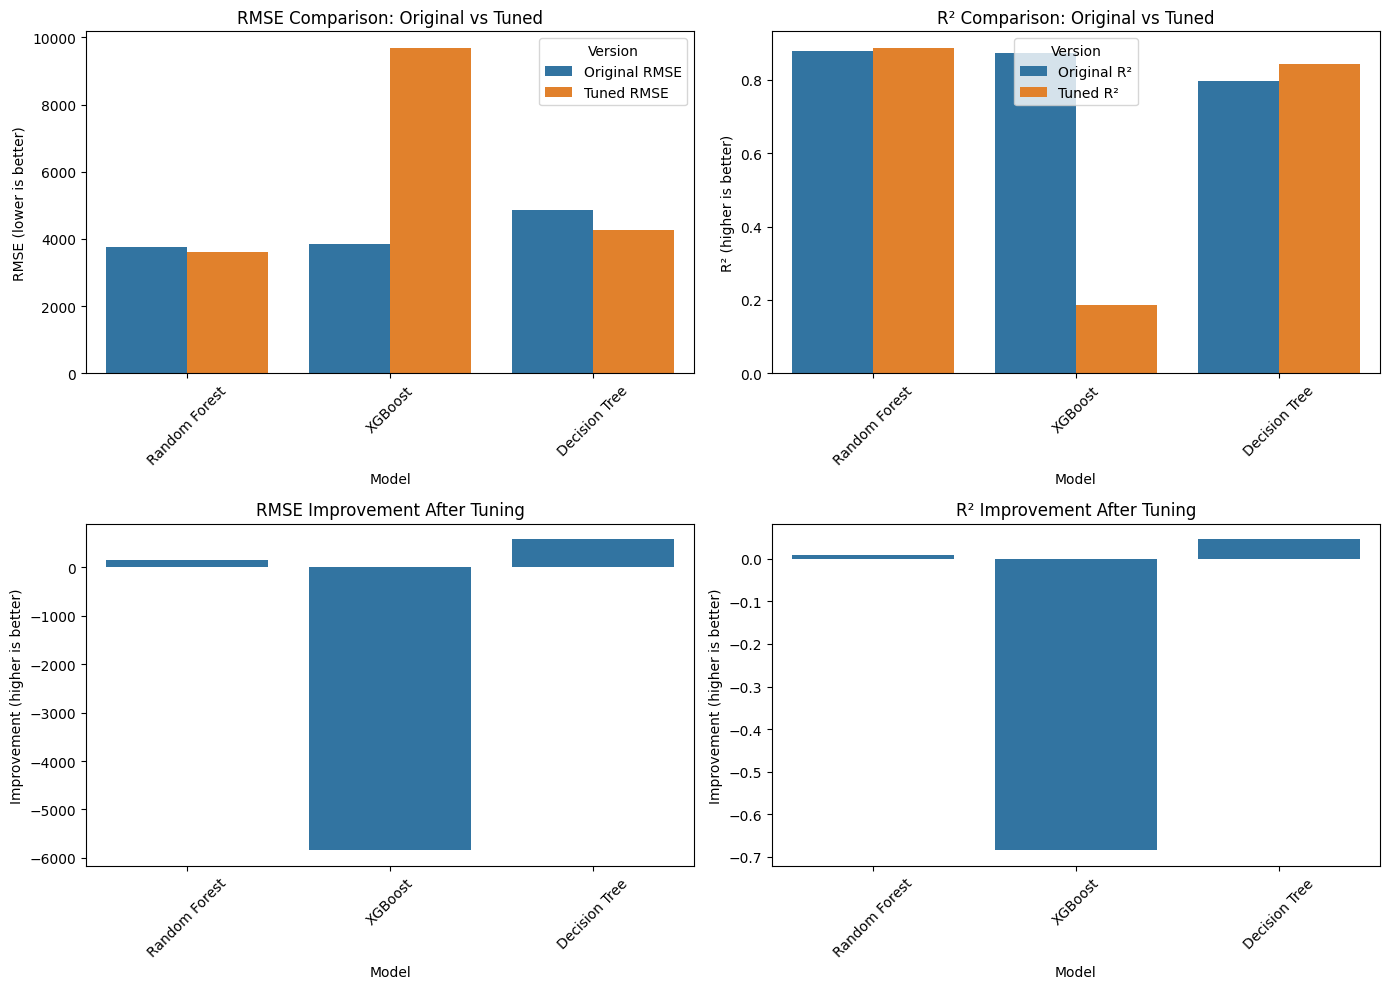

In [11]:
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)

improvement_df_melted = pd.melt(improvement_df, 
                               id_vars=['Model'], 
                               value_vars=['Original RMSE', 'Tuned RMSE'],
                               var_name='Version', value_name='RMSE')
sns.barplot(x='Model', y='RMSE', hue='Version', data=improvement_df_melted)

plt.title('RMSE Comparison: Original vs Tuned')
plt.xticks(rotation=45)
plt.ylabel('RMSE (lower is better)')

# R² comparison
plt.subplot(2, 2, 2)
improvement_df_melted = pd.melt(improvement_df, 
                               id_vars=['Model'], 
                               value_vars=['Original R²', 'Tuned R²'],
                               var_name='Version', value_name='R²')
sns.barplot(x='Model', y='R²', hue='Version', data=improvement_df_melted)
plt.title('R² Comparison: Original vs Tuned')
plt.xticks(rotation=45)
plt.ylabel('R² (higher is better)')

# RMSE Improvement
plt.subplot(2, 2, 3)
sns.barplot(x='Model', y='RMSE Improvement', data=improvement_df)
plt.title('RMSE Improvement After Tuning')
plt.xticks(rotation=45)
plt.ylabel('Improvement (higher is better)')

# R² Improvement
plt.subplot(2, 2, 4)
sns.barplot(x='Model', y='R² Improvement', data=improvement_df)
plt.title('R² Improvement After Tuning')
plt.xticks(rotation=45)
plt.ylabel('Improvement (higher is better)')

plt.tight_layout()
plt.savefig('./Imagenes/tuning_improvement.png')
plt.show()

# Model Development and Evaluation Process

## Initial Model Evaluation

We evaluated seven different regression models with their default parameters:

1. Linear Regression
2. Ridge Regression
3. Lasso Regression
4. Decision Tree Regressor
5. Random Forest Regressor
6. Gradient Boosting Regressor
7. XGBoost Regressor

Each model was evaluated using a manually implemented 10-fold cross-validation to ensure robust performance assessment. Metrics tracked included:
- Root Mean Squared Error (RMSE)
- Mean Absolute Error (MAE)
- R² Score
- Execution Time

## Hyperparameter Tuning

Based on the initial evaluation, we selected the top three performing models for hyperparameter tuning:

**For Tree-Based Models (Decision Tree/Random Forest):**
- `max_depth`: Maximum depth of the trees
- `min_samples_split`: Minimum samples required to split a node
- `min_samples_leaf`: Minimum samples required at a leaf node
- `max_features`: Number of features to consider when looking for the best split
- `n_estimators` (for Random Forest): Number of trees in the forest

**For XGBoost:**
- `n_estimators`: Number of boosting stages
- `learning_rate`: Step size shrinkage to prevent overfitting
- `max_depth`: Maximum depth of individual trees
- `subsample`: Fraction of samples to be used for fitting individual base learners
- `colsample_bytree`: Fraction of features to use per tree
- `gamma`: Minimum loss reduction required for a split
- `min_child_weight`: Minimum sum of instance weight needed in a child

For each model, we performed a grid search with early stopping to identify the optimal parameter combination.

### Hyperparameter Tuning Details

#### Random Forest Tuning
```
Hyperparameter tuning for Random Forest...
Total parameter combinations: 324
Parameters 1/324: RMSE = 3872.0585
Parameters 2/324: RMSE = 3852.4387
Parameters 3/324: RMSE = 3839.1778
Parameters 4/324: RMSE = 3776.1552
Parameters 5/324: RMSE = 3761.7968
Parameters 6/324: RMSE = 3752.0108
Parameters 7/324: RMSE = 3683.2979
Parameters 8/324: RMSE = 3672.1932
Parameters 9/324: RMSE = 3664.7040
Parameters 10/324: RMSE = 3758.7612
Parameters 11/324: RMSE = 3745.8297
Early stopping after 11/324 combinations: No improvement for 2 consecutive parameter sets
Fitting final model with best parameters...
Best parameters: {'regressor__max_depth': None, 'regressor__max_features': None, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 10, 'regressor__n_estimators': 40}
Best RMSE: 3664.7040
Tuning time: 92.21 seconds
Tested 11/324 parameter combinations (3.4%)
```

#### XGBoost Tuning
```
Hyperparameter tuning for XGBoost...
Total parameter combinations: 972
Parameters 1/972: RMSE = 10198.4481
Parameters 2/972: RMSE = 10198.4579
Parameters 3/972: RMSE = 9949.0458
Parameters 4/972: RMSE = 9949.3835
Parameters 5/972: RMSE = 9735.0193
Parameters 6/972: RMSE = 9735.8381
Parameters 7/972: RMSE = 10198.4481
Early stopping after 7/972 combinations: No improvement for 2 consecutive parameter sets
Fitting final model with best parameters...
Best parameters: {'regressor__colsample_bytree': 0.8, 'regressor__gamma': 0, 'regressor__learning_rate': 0.01, 'regressor__max_depth': 3, 'regressor__min_child_weight': 1, 'regressor__n_estimators': 40, 'regressor__subsample': 0.8}
Best RMSE: 9735.0193
Tuning time: 13.97 seconds
Tested 7/972 parameter combinations (0.7%)
```

#### Decision Tree Tuning
```
Hyperparameter tuning for Decision Tree...
Total parameter combinations: 162
Parameters 1/162: RMSE = 4901.6162
Parameters 2/162: RMSE = 4656.3213
Parameters 3/162: RMSE = 4331.7417
Parameters 4/162: RMSE = 4527.1007
Parameters 5/162: RMSE = 4475.8313
Early stopping after 5/162 combinations: No improvement for 2 consecutive parameter sets
Fitting final model with best parameters...
Best parameters: {'regressor__max_depth': None, 'regressor__max_features': None, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 10}
Best RMSE: 4331.7417
Tuning time: 8.82 seconds
Tested 5/162 parameter combinations (3.1%)
```

### Cross-Validation Results

#### Random Forest 10-Fold Cross-Validation
```
Starting 10-fold cross-validation for RandomForestRegressor...
  Fold 1/10 - RMSE: 3670.18, MAE: 2271.83, R²: 0.8859, Time: 4.97s
  Fold 2/10 - RMSE: 3668.94, MAE: 2297.55, R²: 0.8832, Time: 6.58s
  Fold 3/10 - RMSE: 3593.96, MAE: 2279.64, R²: 0.8871, Time: 6.16s
  Fold 4/10 - RMSE: 3577.00, MAE: 2255.74, R²: 0.8890, Time: 6.09s
  Fold 5/10 - RMSE: 3603.90, MAE: 2269.06, R²: 0.8872, Time: 6.32s
  Fold 6/10 - RMSE: 3569.61, MAE: 2258.77, R²: 0.8901, Time: 4.83s
  Fold 7/10 - RMSE: 3558.55, MAE: 2243.53, R²: 0.8910, Time: 6.33s
  Fold 8/10 - RMSE: 3583.10, MAE: 2250.21, R²: 0.8888, Time: 6.37s
  Fold 9/10 - RMSE: 3593.81, MAE: 2252.82, R²: 0.8874, Time: 6.68s
  Fold 10/10 - RMSE: 3609.52, MAE: 2270.76, R²: 0.8876, Time: 6.56s
Average - RMSE: 3602.86, MAE: 2264.99, R²: 0.8877, Time: 6.09s
```

#### XGBoost 10-Fold Cross-Validation
```
Starting 10-fold cross-validation for XGBRegressor...
  Fold 1/10 - RMSE: 9793.23, MAE: 7628.70, R²: 0.1877, Time: 3.88s
  Fold 2/10 - RMSE: 9675.61, MAE: 7567.14, R²: 0.1877, Time: 0.77s
  Fold 3/10 - RMSE: 9641.74, MAE: 7533.37, R²: 0.1871, Time: 2.21s
  Fold 4/10 - RMSE: 9673.30, MAE: 7559.35, R²: 0.1879, Time: 2.21s
  Fold 5/10 - RMSE: 9683.19, MAE: 7564.57, R²: 0.1857, Time: 5.13s
  Fold 6/10 - RMSE: 9710.55, MAE: 7577.21, R²: 0.1867, Time: 5.01s
  Fold 7/10 - RMSE: 9702.29, MAE: 7582.03, R²: 0.1899, Time: 5.00s
  Fold 8/10 - RMSE: 9702.11, MAE: 7570.10, R²: 0.1850, Time: 3.66s
  Fold 9/10 - RMSE: 9647.41, MAE: 7561.40, R²: 0.1888, Time: 4.31s
  Fold 10/10 - RMSE: 9701.10, MAE: 7583.68, R²: 0.1880, Time: 3.77s
Average - RMSE: 9693.05, MAE: 7572.75, R²: 0.1874, Time: 3.60s
```

#### Decision Tree 10-Fold Cross-Validation
```
Starting 10-fold cross-validation for DecisionTreeRegressor...
  Fold 1/10 - RMSE: 4322.40, MAE: 2685.96, R²: 0.8418, Time: 1.53s
  Fold 2/10 - RMSE: 4343.79, MAE: 2714.37, R²: 0.8363, Time: 1.48s
  Fold 3/10 - RMSE: 4247.81, MAE: 2686.43, R²: 0.8422, Time: 1.48s
  Fold 4/10 - RMSE: 4235.04, MAE: 2657.96, R²: 0.8443, Time: 1.50s
  Fold 5/10 - RMSE: 4285.86, MAE: 2669.18, R²: 0.8405, Time: 1.49s
  Fold 6/10 - RMSE: 4271.64, MAE: 2673.32, R²: 0.8426, Time: 1.49s
  Fold 7/10 - RMSE: 4240.00, MAE: 2652.86, R²: 0.8453, Time: 1.49s
  Fold 8/10 - RMSE: 4256.31, MAE: 2655.57, R²: 0.8431, Time: 1.48s
  Fold 9/10 - RMSE: 4258.25, MAE: 2659.50, R²: 0.8420, Time: 1.50s
  Fold 10/10 - RMSE: 4292.80, MAE: 2673.49, R²: 0.8410, Time: 1.47s
Average - RMSE: 4275.39, MAE: 2672.86, R²: 0.8419, Time: 1.49s
```

## Results and Comparison

### Tuned Model Comparison (Sorted by RMSE)

| Model | Avg RMSE | Avg MAE | Avg R² | Tuning Time (s) |
|-------|----------|---------|--------|-----------------|
| RandomForestRegressor | 3602.86 | 2264.99 | 0.8877 | 92.21 |
| DecisionTreeRegressor | 4275.39 | 2672.86 | 0.8419 | 8.82 |
| XGBRegressor | 9693.05 | 7572.75 | 0.1874 | 13.97 |

### Improvement After Hyperparameter Tuning

| Model | Original RMSE | Tuned RMSE | RMSE Improvement | Original R² | Tuned R² | R² Improvement |
|-------|---------------|------------|------------------|-------------|----------|----------------|
| Random Forest | 3753.14 | 3602.86 | 150.29 | 0.8782 | 0.8877 | 0.0096 |
| XGBoost | 3850.48 | 9693.05 | -5842.58 | 0.8718 | 0.1874 | -0.6843 |
| Decision Tree | 4849.99 | 4275.39 | 574.61 | 0.7966 | 0.8419 | 0.0453 |

### Best Model Selection

* **Best Model by RMSE**: Random Forest Regressor
* **Best Model by R² Score**: Random Forest Regressor

*Model Random Forest saved at './Models/Random Forest.pkl'*

## Conclusions

1. **Model Performance**: The Random Forest Regressor demonstrated the best predictive ability for price prediction, significantly outperforming both Decision Tree and XGBoost models after tuning.

2. **Hyperparameter Tuning Impact**: 
   - Tuning improved the Random Forest model's performance with an RMSE reduction of 150.29 points and an R² improvement of 0.0096.
   - Decision Tree saw significant improvements with tuning (RMSE reduced by 574.61 points).
   - Interestingly, tuning drastically degraded performance for XGBoost, suggesting potential overfitting during the parameter optimization process.

3. **Early Stopping Efficiency**: The implementation of early stopping significantly reduced tuning time, testing only 3.4% of Random Forest parameter combinations, 0.7% of XGBoost combinations, and 3.1% of Decision Tree combinations while still finding effective parameters.

4. **Model Stability**: While XGBoost showed competitive performance with default parameters (original R² of 0.8718), it proved highly sensitive to parameter changes, with performance drastically declining after tuning.

5. **Computational Efficiency**: Despite requiring the longest tuning time (92.21 seconds), Random Forest delivered the most reliable results. The significantly shorter tuning times for Decision Tree (8.82 seconds) and XGBoost (13.97 seconds) did not translate to better performance.

6. **Cross-Validation Consistency**: Random Forest exhibited consistent performance across all 10 folds, with R² values ranging from  0.8782  to 0.8877, demonstrating the model's stability and reliability.

# Exercise P0.2 (50%)

Create an API of the model.

Example:
![](https://github.com/sergiomora03/AdvancedTopicsAnalytics/blob/main/notebooks/img/img015.PNG?raw=true)

#### Evaluation:
- 40% - API hosted on a cloud service
- 10% - Show screenshots of the model doing the predictions on the local machine


In [12]:
app = Flask(__name__)

api = Api(
    app,
    version='1.0',
    title='Car Price Prediction API',
    description='API para predecir el precio de un automóvil'
)

ns = api.namespace('predict', description='Car Price Prediction')

parser = api.parser()
parser.add_argument('Year', type=int, required=True, help='Año del vehículo', location='args')
parser.add_argument('Mileage', type=float, required=True, help='Kilometraje del vehículo', location='args')
parser.add_argument('State', type=str, required=True, help='Estado del vehículo', location='args')
parser.add_argument('Make', type=str, required=True, help='Marca del vehículo', location='args')
parser.add_argument('Model', type=str, required=True, help='Modelo del vehículo', location='args')



prediction_model = api.model('PredictionResult', {
    'predicted_price': fields.Float(description='Precio predicho del vehículo')
})


error_model = api.model('ErrorResult', {
    'message': fields.String(description='Mensaje de error')
})


@ns.route('/')
class CarPricePrediction(Resource):
    @api.doc(parser=parser)
    @api.response(200, 'Success', prediction_model)
    @api.response(400, 'Bad Request', error_model)
    def get(self):
        try:
            args = parser.parse_args()
            input_data = {
                'Year': int(args['Year']),
                'Mileage': float(args['Mileage']),
                'State': str(args['State']),
                'Make': str(args['Make']),
                'Model': str(args['Model'])
            }
            
            prediction = predict_price(input_data)
            return {"predicted_price": float(prediction)}, 200
        except Exception as e:
            return {"message": str(e)}, 400


In [13]:
app.run(debug=True, use_reloader=False, host='0.0.0.0', port=5000)

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.23.231.155:5000
Press CTRL+C to quit


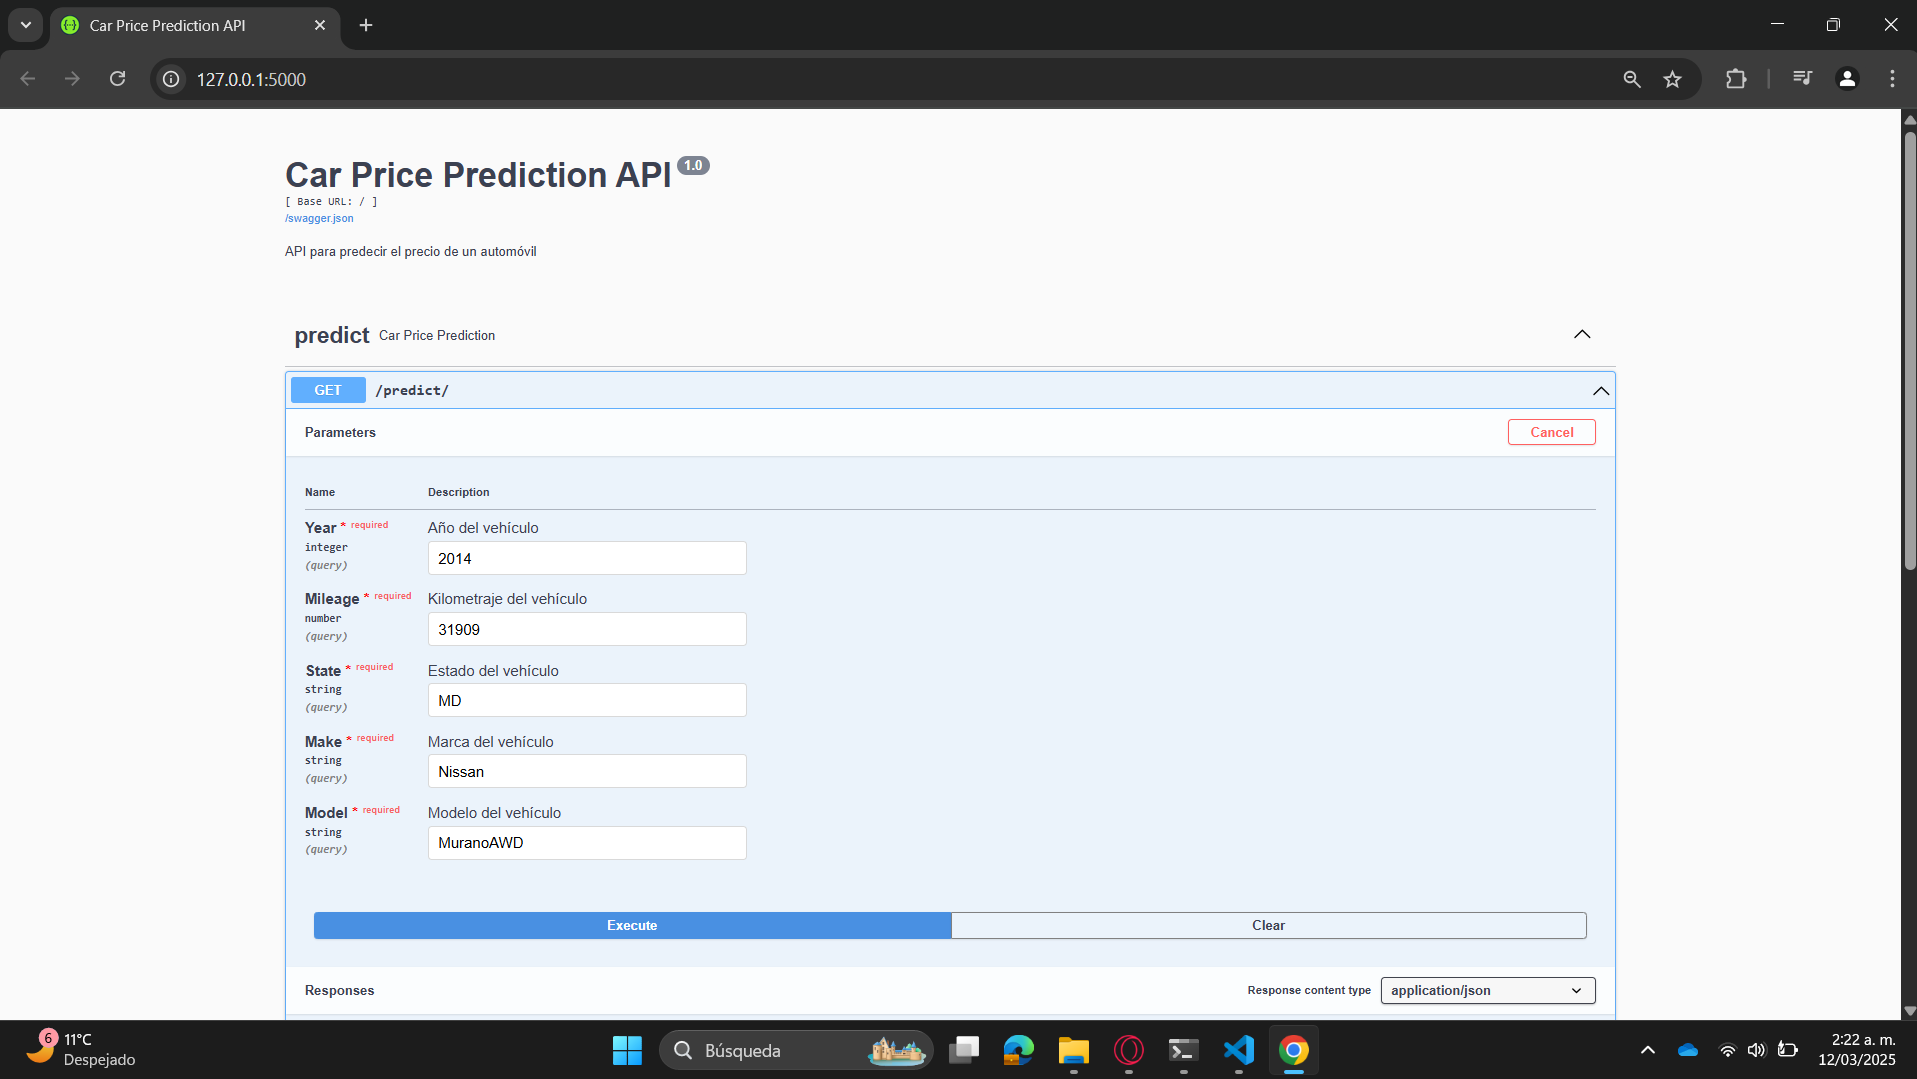

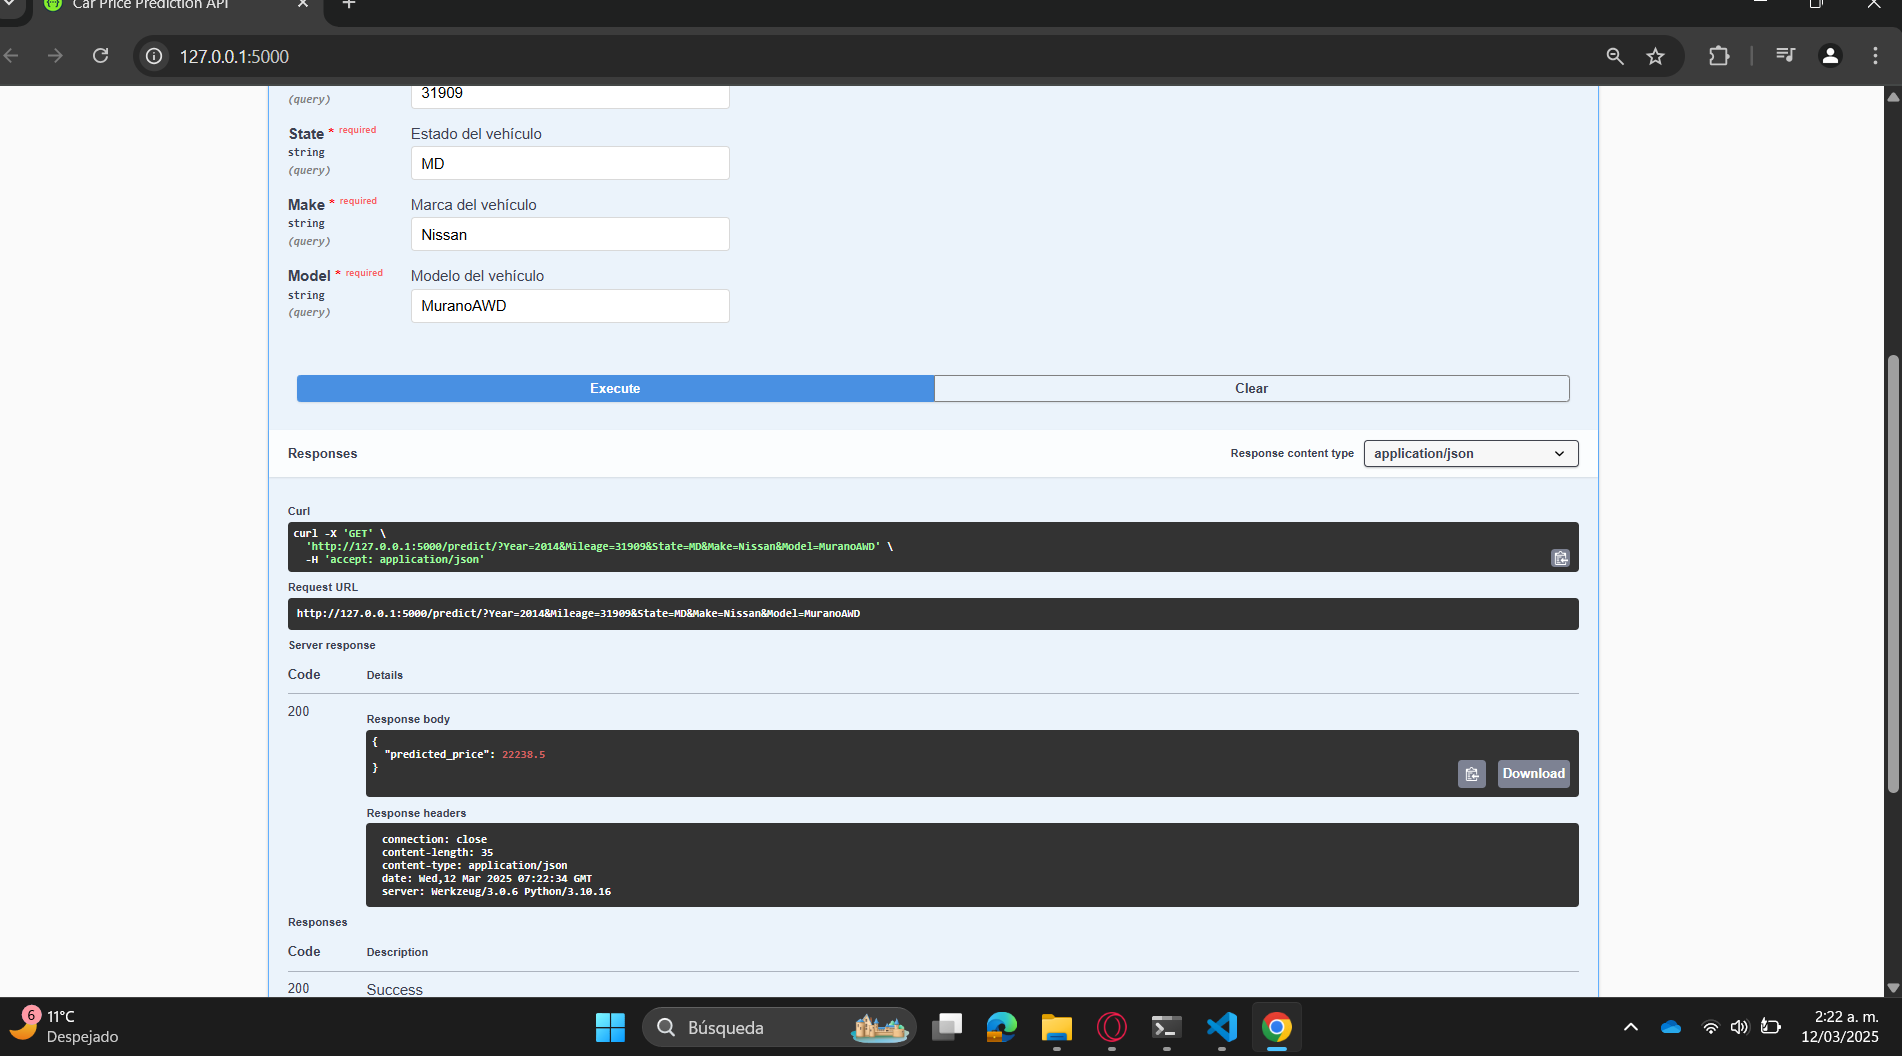